# Problem 1: Solar irradiance predicition
## GEOS images exploration
In this notebook, we will explore the images provided in HDF5 files.

In [3]:
import utils
import numpy as np
import pandas as pd
import cv2
import h5py
import json
import typing
from pathlib import Path
from scipy import interpolate

In [4]:
# We'll start by reading the images from the disk where we sampled files from Jan 2015

with open('pre_process_cfg_local.json', 'r') as fd:
    pre_process_config = json.load(fd)

hdf5_path = pre_process_config["hdf5_path"]
dataframe_path = pre_process_config["dataframe_path"]
stations = pre_process_config["stations"]
target_channels = ["ch1","ch2","ch3","ch4","ch6"]


We will use the provided method to visualize the images

reshaping for final display: 100%|█████████████████████████████████████████████████████| 96/96 [00:02<00:00, 43.54it/s]


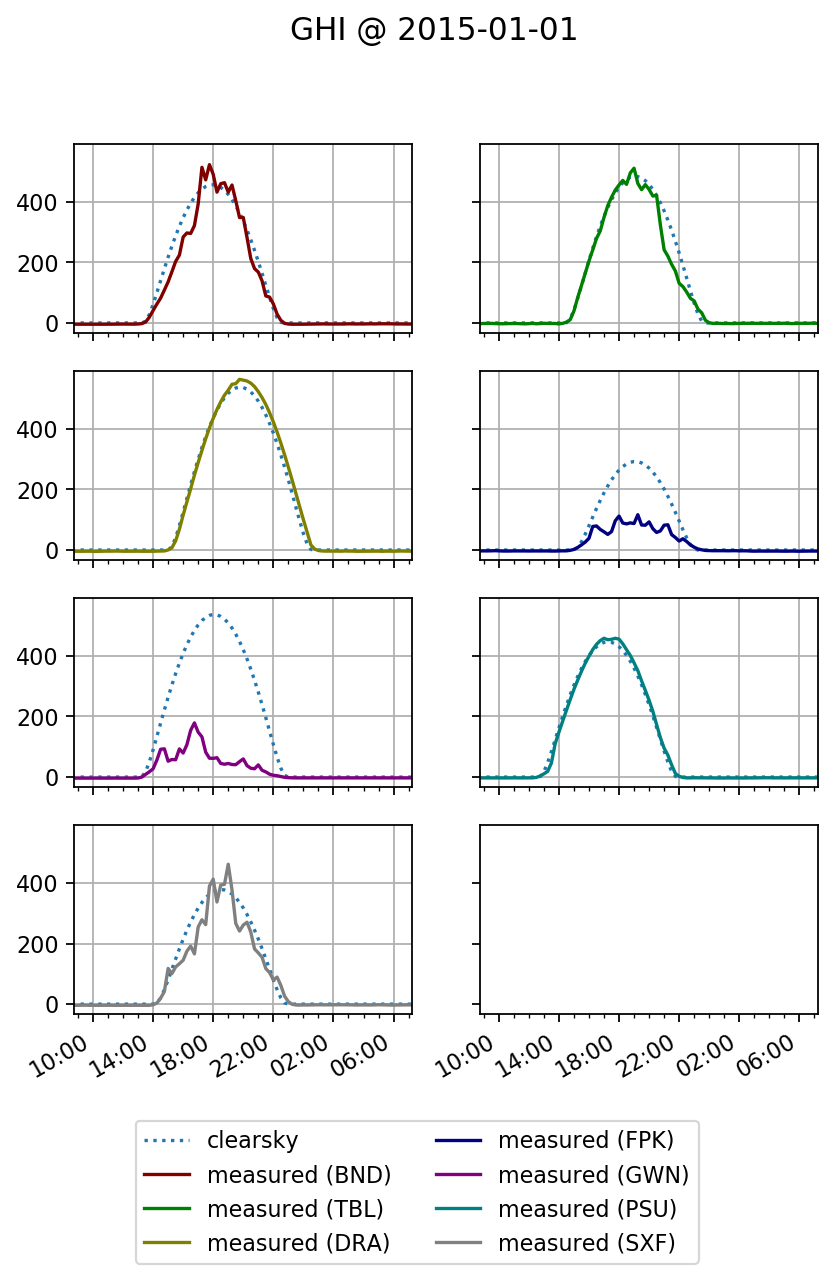

In [3]:
utils.viz_hdf5_imagery(hdf5_path, target_channels, dataframe_path, stations)

Explore the structure of HDF5 file which contains multiple datasets and attributes:

In [8]:
with h5py.File(hdf5_path, 'r') as h5_data:
    print(*list(h5_data.values()),sep = "\n")

<HDF5 dataset "ch1": shape (86,), type "|O">
<HDF5 dataset "ch1_LUT": shape (96,), type "<i4">
<HDF5 dataset "ch2": shape (86,), type "|O">
<HDF5 dataset "ch2_LUT": shape (96,), type "<i4">
<HDF5 dataset "ch3": shape (86,), type "|O">
<HDF5 dataset "ch3_LUT": shape (96,), type "<i4">
<HDF5 dataset "ch4": shape (86,), type "|O">
<HDF5 dataset "ch4_LUT": shape (96,), type "<i4">
<HDF5 dataset "ch6": shape (86,), type "|O">
<HDF5 dataset "ch6_LUT": shape (96,), type "<i4">
<HDF5 dataset "lat": shape (86,), type "|O">
<HDF5 dataset "lat_LUT": shape (96,), type "<i4">
<HDF5 dataset "lon": shape (86,), type "|O">
<HDF5 dataset "lon_LUT": shape (96,), type "<i4">
<HDF5 dataset "ncdf_path": shape (86,), type "|O">
<HDF5 dataset "ncdf_path_LUT": shape (96,), type "<i4">


Explore one channel:

In [9]:
with h5py.File(hdf5_path, 'r') as h5_data:
    ch1 = h5_data["ch1"][()]
    ch1_lut = h5_data["ch1_LUT"][()]
print("ch1 shape = ", ch1.shape)
print("Shape of one timestamp = ", ch1[0].shape)
print("ch1_lut shape = ", ch1_lut.shape)

ch1 shape =  (86,)
Shape of one timestamp =  (36087,)
ch1_lut shape =  (96,)


We notice here that the channel (same thing for the other channel) has missing timestamps images. Also the shape of one timestamp seems to be different for different timestamps. This is due to compression fron ncdf files. The LUT dataset gives the index of the missing images:

In [10]:
# identify offsets which don't have images:
miss_idx = np.where(np.equal(ch1_lut,-1))
print(miss_idx)

(array([ 4, 16, 28, 30, 40, 52, 64, 66, 76, 88]),)


To get the true images, for a goven offset, we have to decompress the dataset using the method provided in utils.py:

In [11]:
def fetch_h5file_offset(hdf5_path,channel,hdf5_offset):
    with h5py.File(hdf5_path, 'r') as h5_data:
        ch1_offset = utils.fetch_hdf5_sample(channel, h5_data, hdf5_offset)
    return ch1_offset

In [12]:
hdf5_offset = 32
channel = "ch1"
fetched_ch1 = fetch_h5file_offset(hdf5_path,channel,hdf5_offset)
print("Shape of the true image: ", fetched_ch1.shape)

Shape of the true image:  (650, 1500)


650x1500 is the size of the image captured by the satellite. The image is monocolor and not in RGB, so we can display it without rescaling:

In [9]:
print("min value = ",fetched_ch1.min())
print("max value = ",fetched_ch1.max())

min value =  -0.01
max value =  1.772157


Let's display it:

In [10]:
cv2.imshow('ch1_32', fetched_ch1)
cv2.waitKey(0) 

119

Remarque: We have to flip the image to have the same display as the presentation!

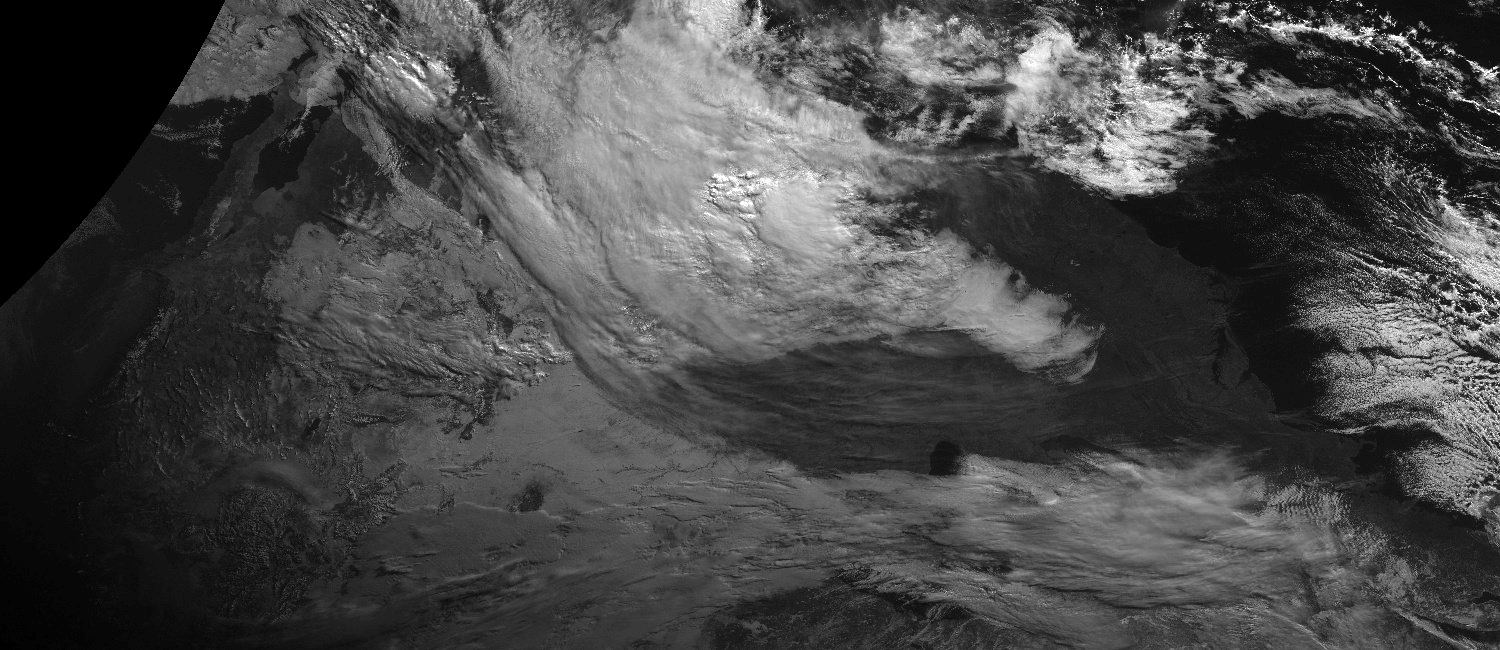

It was interesting to see where the station are located. we need first to get the pixel-wise position from geographic coordinates. We need first to fetch `lat` and `lon` datasets from HDF5 file:

In [13]:
with h5py.File(hdf5_path, 'r') as h5_data:
    lats, lons = utils.fetch_hdf5_sample("lat", h5_data, hdf5_offset),\
                 utils.fetch_hdf5_sample("lon", h5_data, hdf5_offset)

In [14]:
station_data = {}
for reg, coords in stations.items():
    station_coords = (np.argmin(np.abs(lats - coords[0])), np.argmin(np.abs(lons - coords[1])))
    station_data.update({reg: station_coords})
print(station_data)

{'BND': (401, 915), 'TBL': (403, 494), 'DRA': (315, 224), 'FPK': (607, 497), 'GWN': (256, 878), 'PSU': (418, 1176), 'SXF': (493, 709)}


Let's display the previous image with the positions of the stations. We will use the same method to crop the image at the same position in order to train the model.

In [15]:
def display_crop_img(img,window,stations_coord):
    
    for i,j in enumerate(stations_coord):
        cv2.rectangle(img, (stations_coord[j][1]-window, stations_coord[j][0]-window), 
                      (stations_coord[j][1]+window, stations_coord[j][0]+window), (255,255,255), 2)
        cv2.putText(img,j,
                    (stations_coord[j][1]-15,stations_coord[j][0]-30),cv2.FONT_HERSHEY_COMPLEX,0.5,(255,255,255),1)
    
    # we have to flip the image to get the good position on the image!
    img = cv2.flip(img, 0) 
    
    return img


In [14]:
crop_img = display_crop_img(fetched_ch1,20,station_data)
cv2.imshow("GEOS Stations", crop_img)
cv2.waitKey(0)

113

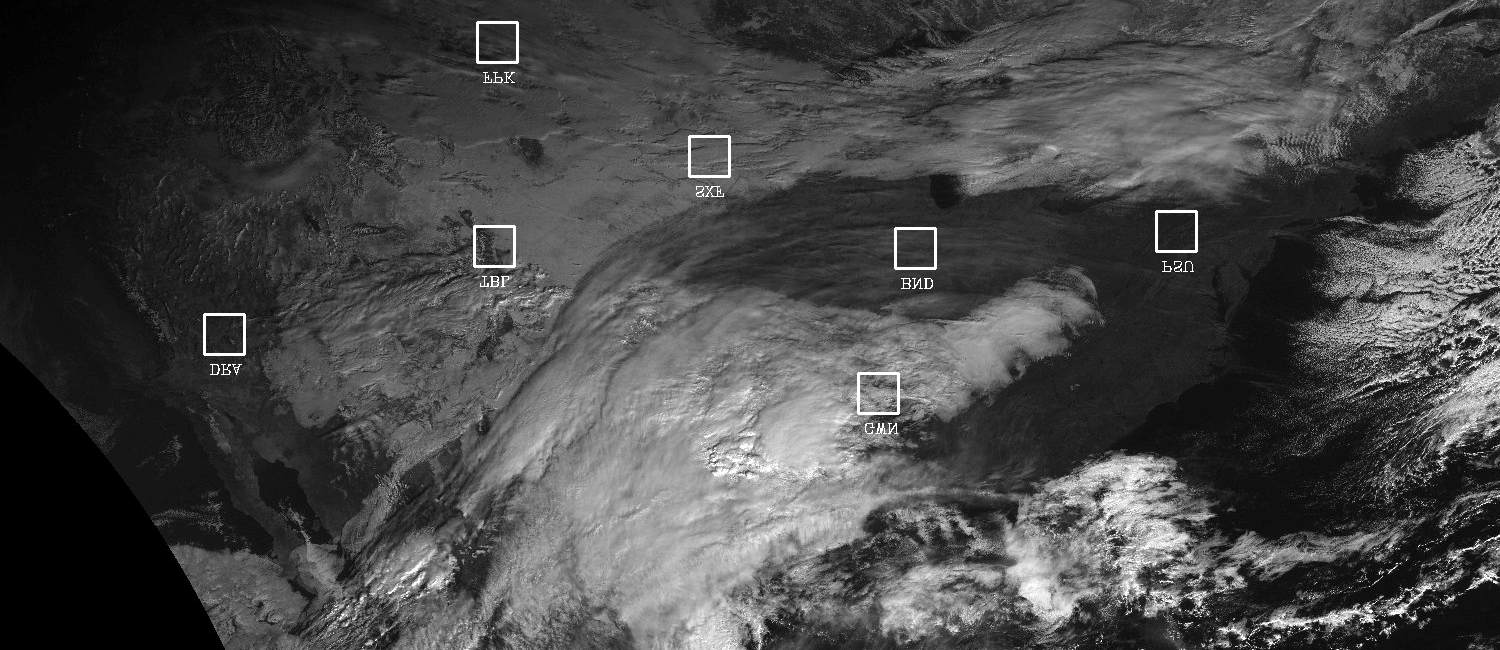

## Croping the images

## Handling missing images

We have seen in the ch1_lut dataset that we have missing images for a specific timestamp that is represented by `-1`:

In [15]:
ch1_lut

array([ 0,  1,  2,  3, -1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, -1, 26, -1, 27, 28, 29,
       30, 31, 32, 33, 34, 35, -1, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, -1, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, -1, 58, -1, 59,
       60, 61, 62, 63, 64, 65, 66, 67, -1, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, -1, 79, 80, 81, 82, 83, 84, 85])

In order to fill these gaps, we define the following methods, which will take an interpolation pixel wise from the previous offset to the next offset:

In [16]:
def handle_missing_img(prev_img, next_img):
    # flatten and stack the images vertically
    missing_vec = np.ravel(np.zeros(prev_img.shape))
    stack = np.vstack((np.ravel(prev_img), missing_vec, np.ravel(next_img)))
    interp_img = interpolate_images(stack)

    return interp_img[1].reshape(prev_img.shape)

def interpolate_images(data):
    print("Interpolating missing image ...")
    data2 = np.copy(data.astype(float))
    for i in range(0, data.shape[1]):
        col_values = data2[:, i]
        col_idx = np.arange(len(col_values))
        # idx of non-zero values
        idx = np.where(col_values != 0)
        # create instance of interp1d
        interp = interpolate.interp1d(col_idx[idx], col_values[idx], kind='linear')
        # interpolate column wise
        new_col_values = interp(col_idx)
        data2[:, i] = new_col_values

    return data2



In [17]:
# Experiment 1: fill the gap at index 40
ch1_lut[4]

-1

In [17]:
# make sure we don't have image at this offset
missing_img = fetch_h5file_offset(hdf5_path, "ch1", 40)
print(missing_img)

None


We suppose that we reach a missing image at index 40

In [18]:
# We start by fetching the previous and the next images
cur_offset = 40
prev_img = fetch_h5file_offset(hdf5_path, "ch1", cur_offset - 1)
next_img = fetch_h5file_offset(hdf5_path, "ch1", cur_offset + 1)

interp_img = handle_missing_img(prev_img, next_img)

Interpolating missing image ...


In [20]:
interp_img.shape

(650, 1500)

The interpolated image has the same shape as the previous and next one, and looks like a good approximation as it looks like a good transition from the previous to the next one

In [21]:
# Previous image
cv2.imshow("Previous image",prev_img)
cv2.waitKey(0)

113

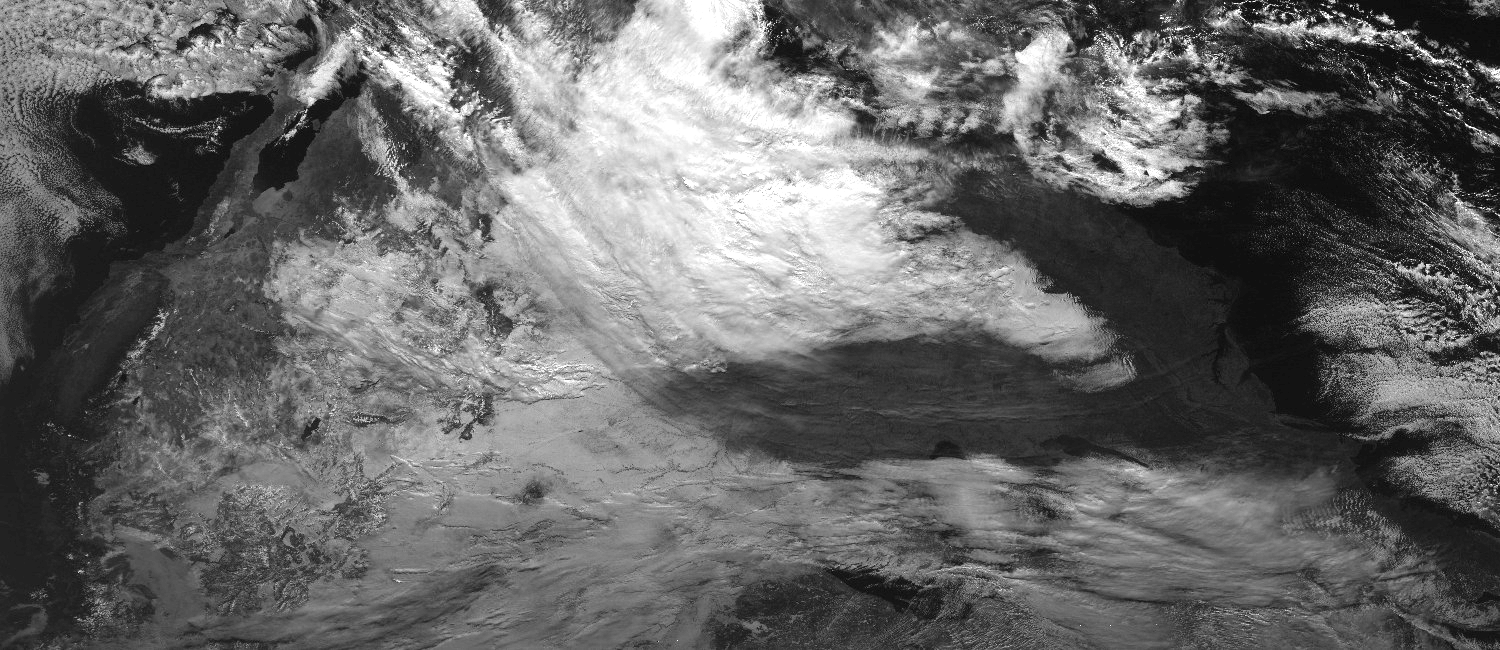

In [22]:
# Interpolated image
cv2.imshow("Interpolated image",interp_img)
cv2.waitKey(0)

115

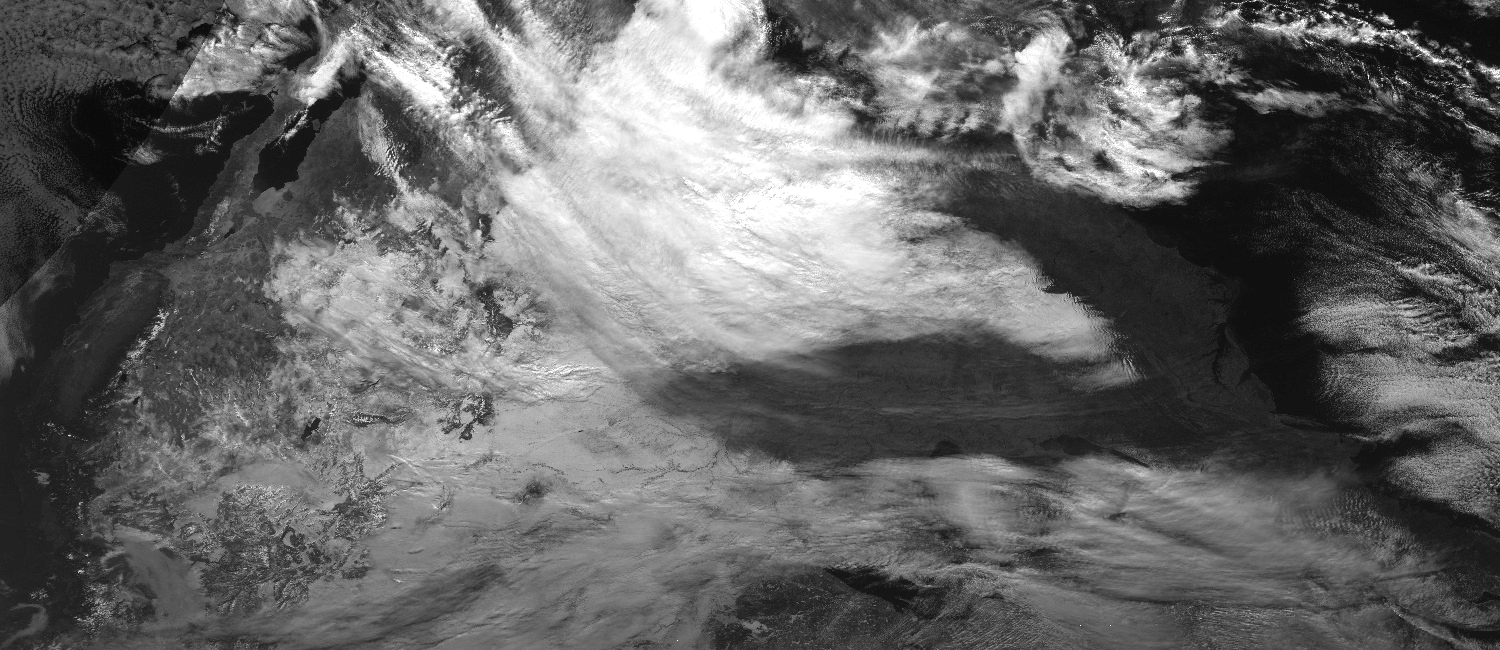

In [23]:
# Next image
cv2.imshow("Next image",next_img)
cv2.waitKey(0)

115

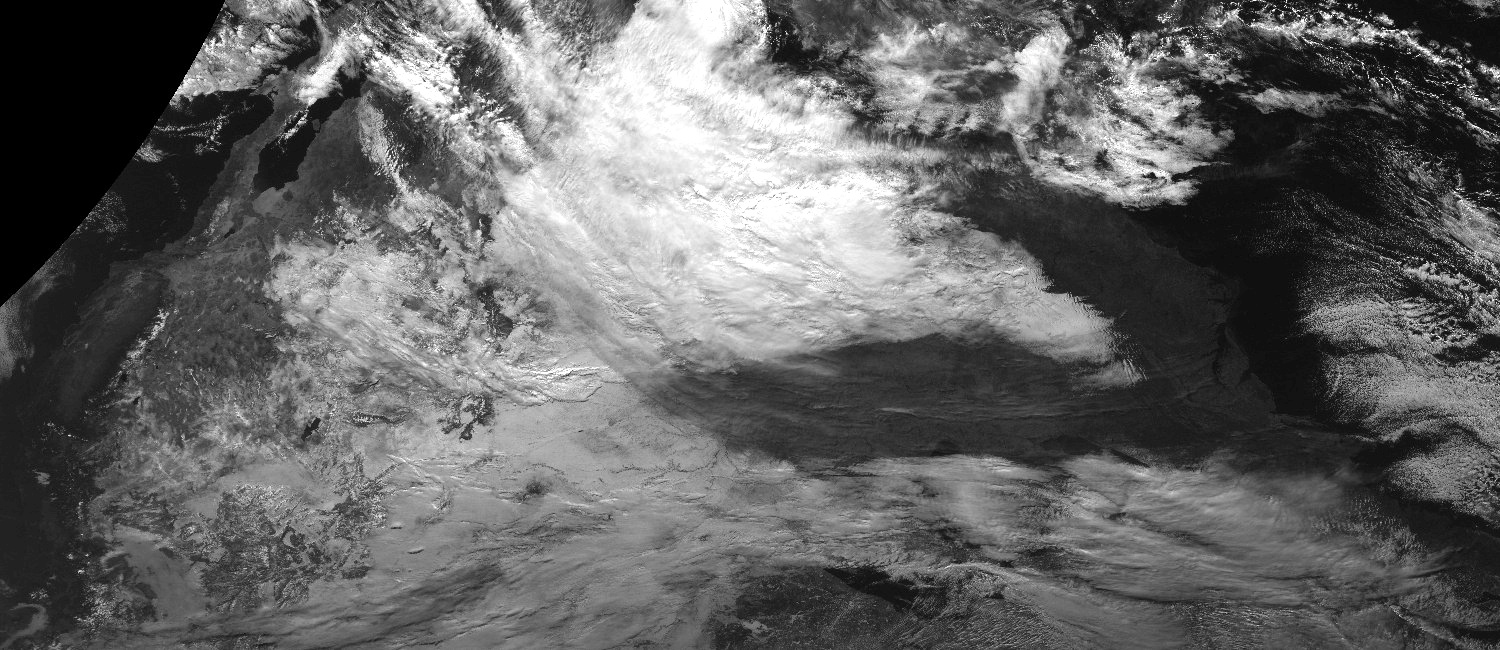